<a href="https://colab.research.google.com/github/Elena-Lebedeva/drafts/blob/main/SMS_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import nltk   
import matplotlib.pyplot as plt

import re                                  # library for regular expression operations
import string                              # for string operations

from collections import Counter

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings
from wordcloud import WordCloud

In [ ]:
from nltk import pos_tag, RegexpParser

In [ ]:
from nltk.tokenize import PunktSentenceTokenizer, word_tokenize, sent_tokenize

In [ ]:
df = pd.read_csv('clean_nus_sms.csv')

In [ ]:
df.sample(10)

,Unnamed: 0,id,Message,length,country,Date
7719,8001,18121,Hey sorry ah... Ü free this sun?,32,SG,2003/4
15078,16399,6283,At 3 da..,9,India,2011/2
7408,7689,17809,m thai. what do u do?,21,SG,2003/4
17713,19720,9604,<#> should be it,17,United States,2011/2
21014,23272,13156,"Hi Jace, dinner on today? What time should I h...",54,India,2011/3
15689,17108,6992,Hw lng did u slpt.,18,India,2011/2
4111,4299,14419,Yes boss.. Then let me know whether meeting be...,79,SG,2003/4
2799,2943,13063,u busy ? called u but no one ans,32,SG,2003/4
40612,46761,36645,:P saw it coming! Yeah today only chem! Hahaha...,443,Singapore,2011/12
27945,30711,20595,"oo,. ok.. then u gt go out fetch da jie? haha",45,Singapore,2011/3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48598 entries, 0 to 48597
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  48598 non-null  int64 
 1   id          48598 non-null  int64 
 2   Message     48595 non-null  object
 3   length      48598 non-null  object
 4   country     48598 non-null  object
 5   Date        48598 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


In [ ]:
pd.DataFrame(round((df.isna().mean()*100),3)).style.background_gradient(cmap='Blues').format('{:.4f}')

,0
Unnamed: 0,0.0000
id,0.0000
Message,0.0060
length,0.0000
country,0.0000
Date,0.0000


In [ ]:
df = df.dropna(subset=['Message', 'length'])

In [ ]:
df.duplicated().sum()

0

In [ ]:
df['length']= pd.to_numeric(df['length'], errors='coerce')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m').dt.strftime('%m/%Y')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df['country'].value_counts().to_frame().style.background_gradient(cmap='Blues')

,country
Singapore,22013
SG,9804
India,6901
United States,3749
USA,1931
Sri Lanka,1017
Malaysia,766
Pakistan,751
unknown,602
Canada,198


In [ ]:
df.loc[df['country'] == 'SG', 'country'] = 'Singapore' 
df.loc[df['country'] == 'USA', 'country'] = 'United States' 
df.loc[df['country'] == 'india', 'country'] = 'India' 
df.loc[df['country'] == 'INDIA', 'country'] = 'India' 
df.loc[df['country'] == 'UK', 'country'] = 'United Kingdom' 
df.loc[df['country'] == 'srilanka', 'country'] = 'Sri Lanka' 
df.loc[df['country'] == 'MY', 'country'] = 'Malaysia' 

In [ ]:
df['country'].value_counts().head(10).to_frame().style.background_gradient(cmap='Blues')

,country
Singapore,31817
India,7085
United States,5680
Sri Lanka,1047
Malaysia,767
Pakistan,751
unknown,602
Canada,198
Bangladesh,126
China,107


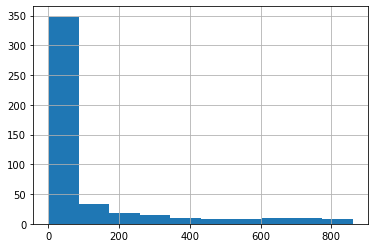

In [ ]:
df['length'].value_counts().hist()
plt.show() 

In [ ]:
count_by_sms_length = df.groupby('country')['length'].agg(['count' ,'mean']).sort_values(by='mean',ascending=False)
count_by_sms_length.head(10).style.background_gradient(cmap='Blues').format('{:.2f}')

,count,mean
country,,
Canada,198.00,103.78
Sri Lanka,1047.00,94.49
Macedonia,10.00,92.20
Ghana,18.00,73.50
Singapore,31814.00,56.00
Nigeria,10.00,54.60
United States,5679.00,53.98
China,107.00,53.65
Malaysia,767.00,51.25


In [ ]:
count_by_sms_length.tail(5).style.background_gradient(cmap='Blues').format('{:.2f}')

,count,mean
country,,
Serbia,22.00,25.00
Turkey,10.00,24.20
Nepal,39.00,18.44
New Zealand,10.00,18.10
Morocco,9.00,11.78


# Preprocess raw text

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split into words -> convert string into list ( 'hello world' -> ['hello', 'world'])
    words = letters_only_text.lower().split()
    
    stemmer = PorterStemmer()

    # stemmer
    stemmed_words = []
    for word in words:
        if word not in stop_words:
            word = stemmer.stem(word)
            stemmed_words.append(word)
    
    # converting list back to string
    return " ".join(stemmed_words)

In [ ]:
test_sentence = df['Message'][2]
print(test_sentence)
print(preprocess(test_sentence))

I dunno until when... Lets go learn pilates...
dunno let go learn pilat


In [ ]:
df["Message_processed"] = df["Message"]
df["Message_processed"] = df["Message_processed"].apply(preprocess)

In [ ]:
df.sample(5)

,Unnamed: 0,id,Message,length,country,Date,Message_processed
29518,32370,22254,Aww no fate. :-(,16.0,Singapore,2011-04-01,aww fate
34153,37593,27477,"Okok, tapao for u tight",23.0,Malaysia,2011-04-01,okok tapao u tight
43021,49326,39210,Reaching soon?,14.0,Singapore,2011-12-01,reach soon
41423,47601,37485,Hahaha jyjy!! Cannot let your prom fail! Haha ...,73.0,Singapore,2011-12-01,hahaha jyji cannot let prom fail haha yeah us ...
30549,33526,23410,Haha never mind eh your birthday still got cha...,52.0,Singapore,2011-04-01,haha never mind eh birthday still got chanc


In [ ]:
# this is one list of list with tokens from sms
list_tokenized_sentences = []
for i in range(len(df['Message_processed'])):
        try: 
            tokenized_sentence =df['Message_processed'][i].split()
            list_tokenized_sentences.append(tokenized_sentence)
        except: 
            continue

In [ ]:
list_tokenized_sentences

[['bugi', 'oso', 'near', 'wat'],
 ['go',
  'jurong',
  'point',
  'crazi',
  'avail',
  'bugi',
  'n',
  'great',
  'world',
  'la',
  'e',
  'buffet',
  'cine',
  'got',
  'amor',
  'wat'],
 ['dunno', 'let', 'go', 'learn', 'pilat'],
 ['den',
  'weekday',
  'got',
  'special',
  'price',
  'haiz',
  'cant',
  'eat',
  'liao',
  'cut',
  'nail',
  'oso',
  'muz',
  'wait',
  'finish',
  'drivin',
  'wat',
  'lunch',
  'still',
  'muz',
  'eat',
  'wat'],
 ['meet', 'lunch', 'la'],
 ['walk', 'citylink', 'faster', 'come', 'hungri'],
 ['night', 'nt', 'stay', 'port', 'step', 'liao', 'ex'],
 ['hey', 'pple', 'night', 'excel', 'locat', 'wif', 'breakfast', 'hamper'],
 ['yun',
  'ah',
  'ubi',
  'one',
  'say',
  'wan',
  'call',
  'tomorrow',
  'call',
  'look',
  'iren',
  'ere',
  'got',
  'bu',
  'ubi',
  'cre',
  'ubi',
  'tech',
  'park',
  'ph',
  'st',
  'wkg',
  'day',
  'n'],
 ['hey', 'tmr', 'mayb', 'meet', 'yck'],
 ['oh', 'ask', 'fun', 'haha', 'take', 'care'],
 ['suppos',
  'meet',
  '

In [ ]:
# this is one list made of all tokens from sms
list_tokenized_words = " ".join(df["Message_processed"]).split()
list_tokenized_words

['bugi',
 'oso',
 'near',
 'wat',
 'go',
 'jurong',
 'point',
 'crazi',
 'avail',
 'bugi',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amor',
 'wat',
 'dunno',
 'let',
 'go',
 'learn',
 'pilat',
 'den',
 'weekday',
 'got',
 'special',
 'price',
 'haiz',
 'cant',
 'eat',
 'liao',
 'cut',
 'nail',
 'oso',
 'muz',
 'wait',
 'finish',
 'drivin',
 'wat',
 'lunch',
 'still',
 'muz',
 'eat',
 'wat',
 'meet',
 'lunch',
 'la',
 'walk',
 'citylink',
 'faster',
 'come',
 'hungri',
 'night',
 'nt',
 'stay',
 'port',
 'step',
 'liao',
 'ex',
 'hey',
 'pple',
 'night',
 'excel',
 'locat',
 'wif',
 'breakfast',
 'hamper',
 'yun',
 'ah',
 'ubi',
 'one',
 'say',
 'wan',
 'call',
 'tomorrow',
 'call',
 'look',
 'iren',
 'ere',
 'got',
 'bu',
 'ubi',
 'cre',
 'ubi',
 'tech',
 'park',
 'ph',
 'st',
 'wkg',
 'day',
 'n',
 'hey',
 'tmr',
 'mayb',
 'meet',
 'yck',
 'oh',
 'ask',
 'fun',
 'haha',
 'take',
 'care',
 'suppos',
 'meet',
 'discuss',
 'abt',
 'trip',
 'thought',
 'xuhui',


## Word frequency

In [ ]:
#let's check the most common words in the dataframe
word_counter_list = Counter(list_tokenized_words).most_common(25)
word_counter_df = pd.DataFrame (word_counter_list, columns = ['word', "frequency"])
word_counter_df.style.background_gradient(cmap='Blues')

,word,frequency
0,u,10299
1,haha,7009
2,go,4921
3,lol,3540
4,got,2548
5,ok,2441
6,time,2192
7,come,2051
8,hahaha,1822
9,okay,1741


In [ ]:
# this is the list where each element is tokenized sms
sms_one_list = df["Message_processed"].tolist()
sms_one_list 

['bugi oso near wat',
 'go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'dunno let go learn pilat',
 'den weekday got special price haiz cant eat liao cut nail oso muz wait finish drivin wat lunch still muz eat wat',
 'meet lunch la',
 'walk citylink faster come hungri',
 'night nt stay port step liao ex',
 'hey pple night excel locat wif breakfast hamper',
 'yun ah ubi one say wan call tomorrow call look iren ere got bu ubi cre ubi tech park ph st wkg day n',
 'hey tmr mayb meet yck',
 'oh ask fun haha take care',
 'suppos meet discuss abt trip thought xuhui told afternoon thought go lesson',
 'finish film yet',
 'dinner cousin',
 'oh kay sat right',
 'need coz never go',
 'basic yoga cours bugi go pilat intro next sat tell time r free',
 'go sao mu today done',
 'hey gal u wanna meet dinner n te',
 'jo ask u wana meet',
 'haiyoh mayb hamster jealou million',
 'hamster dead hey tmr meet pm orchard mrt',
 'book pilat yoga lesson alreadi haha',
 'yup have

In [ ]:
# this is the whole corpus of sms all together as if it was one written piece
sms_all_string = " ".join(sms_one_list) # all sms together as if it was one text
sms_all_merged = []
sms_all_merged.append(sms_all_string)
sms_all_merged 

['bugi oso near wat go jurong point crazi avail bugi n great world la e buffet cine got amor wat dunno let go learn pilat den weekday got special price haiz cant eat liao cut nail oso muz wait finish drivin wat lunch still muz eat wat meet lunch la walk citylink faster come hungri night nt stay port step liao ex hey pple night excel locat wif breakfast hamper yun ah ubi one say wan call tomorrow call look iren ere got bu ubi cre ubi tech park ph st wkg day n hey tmr mayb meet yck oh ask fun haha take care suppos meet discuss abt trip thought xuhui told afternoon thought go lesson finish film yet dinner cousin oh kay sat right need coz never go basic yoga cours bugi go pilat intro next sat tell time r free go sao mu today done hey gal u wanna meet dinner n te jo ask u wana meet haiyoh mayb hamster jealou million hamster dead hey tmr meet pm orchard mrt book pilat yoga lesson alreadi haha yup havent want go yoga call book k must book huh go yoga basic sunday hey sat go intro pilat kickbo

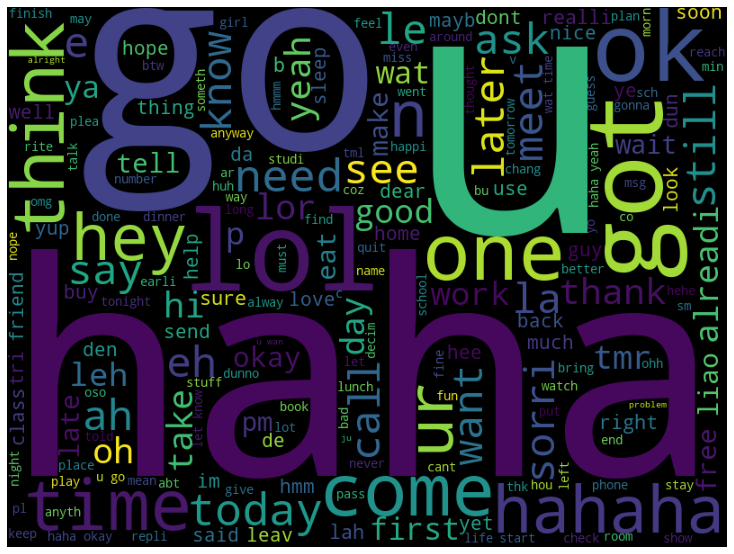

In [ ]:
wordcloud = WordCloud(width = 800, height = 600, background_color ='black', min_font_size = 10).generate(sms_all_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## NATURAL LANGUAGE PARSING WITH REGULAR EXPRESSIONS

In [ ]:
# nltk.download('averaged_perceptron_tagger')
# create a list to hold part-of-speech tagged sentences here
pos_tagged_sms = pos_tag(list_tokenized_words) # list_tokenized_words
pos_tagged_sms

[('bugi', 'NN'),
 ('oso', 'NN'),
 ('near', 'IN'),
 ('wat', 'NN'),
 ('go', 'VBP'),
 ('jurong', 'JJ'),
 ('point', 'NN'),
 ('crazi', 'NN'),
 ('avail', 'NN'),
 ('bugi', 'NN'),
 ('n', 'RB'),
 ('great', 'JJ'),
 ('world', 'NN'),
 ('la', 'NN'),
 ('e', 'VBP'),
 ('buffet', 'JJ'),
 ('cine', 'NN'),
 ('got', 'VBD'),
 ('amor', 'JJ'),
 ('wat', 'NN'),
 ('dunno', 'NN'),
 ('let', 'VBD'),
 ('go', 'VB'),
 ('learn', 'JJ'),
 ('pilat', 'JJ'),
 ('den', 'NN'),
 ('weekday', 'NN'),
 ('got', 'VBD'),
 ('special', 'JJ'),
 ('price', 'NN'),
 ('haiz', 'NN'),
 ('cant', 'JJ'),
 ('eat', 'NN'),
 ('liao', 'NN'),
 ('cut', 'NN'),
 ('nail', 'NN'),
 ('oso', 'NN'),
 ('muz', 'NN'),
 ('wait', 'VBP'),
 ('finish', 'JJ'),
 ('drivin', 'NN'),
 ('wat', 'NN'),
 ('lunch', 'NN'),
 ('still', 'RB'),
 ('muz', 'VBZ'),
 ('eat', 'JJ'),
 ('wat', 'JJ'),
 ('meet', 'NN'),
 ('lunch', 'NN'),
 ('la', 'NN'),
 ('walk', 'VBP'),
 ('citylink', 'VBP'),
 ('faster', 'RBR'),
 ('come', 'JJ'),
 ('hungri', 'NN'),
 ('night', 'NN'),
 ('nt', 'NN'),
 ('stay', 'NN'),


In [ ]:
# function that pulls chunks out of chunked sentence and finds the most common chunks

def chunk_counter(chunked_sentences):

    # create a list to hold chunks
    chunks = []

    # for-loop through each chunked sentence to extract noun phrase chunks
    for chunked_sentence in chunked_sentences:
        for subtree in chunked_sentence.subtrees(filter=lambda t: t.label() == 'Chunk'):
            chunks.append(tuple(subtree))

    # create a Counter object
    chunk_counter = Counter()

    # for-loop through the list of chunks
    for chunk in chunks:
        # increase counter of specific chunk by 1
        chunk_counter[chunk] += 1

    # return 30 most frequent chunks
    return chunk_counter.most_common(30)

In [ ]:
# from nltk import RegexpParser

# define your own chunk grammar here
chunk_grammar = '''Chunk: {<VB.*><NN>}
													}<DT.?|IN|RB|CC>+{'''

# create RegexpParser object
chunk_parser = RegexpParser(chunk_grammar)

# create a list to hold chunked sentences
chunked_sms = []

# chunk each sentence and append to chunked_sms
chunked_sms.append(chunk_parser.parse(pos_tagged_sms))

# store and print the most common chunks
most_common_chunks = chunk_counter(chunked_sms)

In [ ]:
chunks_counter_df = pd.DataFrame (most_common_chunks, columns = ['chunk', "frequency"])
chunks_counter_df

,chunk,frequency
0,"((go, VBP), (home, NN))",158
1,"((take, VB), (care, NN))",73
2,"((take, VBP), (care, NN))",72
3,"((reach, VBP), (home, NN))",55
4,"((come, VBN), (home, NN))",45
5,"((go, VB), (home, NN))",40
6,"((got, VBD), (time, NN))",35
7,"((want, VBP), (eat, NN))",32
8,"((go, VBP), (shop, NN))",31
9,"((go, VBP), (eat, NN))",31


In [ ]:
# function that pulls chunks out of chunked sentence and finds the most common chunks
def np_chunk_counter(chunked_sentences):

    # create a list to hold chunks
    chunks = []

    # for-loop through each chunked sentence to extract noun phrase chunks
    for chunked_sentence in chunked_sentences:
        for subtree in chunked_sentence.subtrees(filter=lambda t: t.label() == 'NP'):
            chunks.append(tuple(subtree))

    # create a Counter object
    chunk_counter = Counter()

    # for-loop through the list of chunks
    for chunk in chunks:
        # increase counter of specific chunk by 1
        chunk_counter[chunk] += 1

    # return 30 most frequent chunks
    return chunk_counter.most_common(30)


In [ ]:
# define noun-phrase chunk grammar here
chunk_grammar = "NP: {<DT>?<JJ>*<NN>}"

# create RegexpParser object here
chunk_parser = RegexpParser(chunk_grammar)

# create a list to hold noun-phrase chunked sentences
chunked_sms = []

# chunk each sentence and append to chunked_sms
chunked_sms.append(chunk_parser.parse(pos_tagged_sms))

# store and print the most common np-chunks here
most_common_np_chunks = np_chunk_counter(chunked_sms)


In [ ]:
chunks_counter_df = pd.DataFrame (most_common_np_chunks, columns = ['chunk', "frequency"])
chunks_counter_df

,chunk,frequency
0,"((haha, NN),)",4140
1,"((lol, NN),)",1688
2,"((home, NN),)",1125
3,"((hahaha, NN),)",1109
4,"((hey, NN),)",1031
5,"((time, NN),)",991
6,"((today, NN),)",956
7,"((call, NN),)",847
8,"((u, NN),)",791
9,"((le, NN),)",768


In [ ]:
# function that pulls chunks out of chunked sentence and finds the most common chunks
def vp_chunk_counter(chunked_sentences):

    # create a list to hold chunks
    chunks = []

    # for-loop through each chunked sentence to extract verb phrase chunks
    for chunked_sentence in chunked_sentences:
        for subtree in chunked_sentence.subtrees(filter=lambda t: t.label() == 'VP'):
            chunks.append(tuple(subtree))

    # create a Counter object
    chunk_counter = Counter()

    # for-loop through the list of chunks
    for chunk in chunks:
        # increase counter of specific chunk by 1
        chunk_counter[chunk] += 1

    # return 30 most frequent chunks
    return chunk_counter.most_common(30)

In [ ]:
# define verb phrase chunk grammar here
chunk_grammar = "VP: {<DT>?<JJ>*<NN><VB.*><RB.?>?}"

# create RegexpParser object here
chunk_parser = RegexpParser(chunk_grammar)

# create a list to hold verb-phrase chunked sentences
chunked_sms = []

# create for loop through each pos-tagged sentence in pos_tagged_oz here
chunked_sms.append(chunk_parser.parse(pos_tagged_sms))
  
# store and print the most common vp-chunks here
most_common_chunks = vp_chunk_counter(chunked_sms)

In [ ]:
chunks_counter_df = pd.DataFrame (most_common_chunks, columns = ['chunk', "frequency"])
chunks_counter_df

,chunk,frequency
0,"((let, NN), (know, VB))",73
1,"((dun, NN), (want, VBP))",59
2,"((wanna, NN), (go, VBP))",56
3,"((haha, NN), (go, VBP))",55
4,"((help, NN), (u, VB))",47
5,"((u, NN), (know, VBP))",46
6,"((dont, NN), (know, VBP))",42
7,"((haha, NN), (got, VBD))",41
8,"((haha, NN), (think, VBP))",38
9,"((u, NN), (go, VBP))",37


## BAG-OF-WORDS LANGUAGE MODEL

Building a Features Dictionary

In [ ]:
import nltk, re
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = stopwords.words('english')
normalizer = WordNetLemmatizer()

def get_part_of_speech(word):
  probable_part_of_speech = wordnet.synsets(word)
  pos_counts = Counter()
  pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
  most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
  return most_likely_part_of_speech

def preprocess_text(text):
  cleaned = re.sub(r'\W+', ' ', text).lower()
  tokenized = word_tokenize(cleaned)
  normalized = [normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
  return normalized

In [ ]:
# Define create_features_dictionary():

def create_features_dictionary(documents):
  features_dictionary = {}
  merged = " ".join(documents)
  tokens = preprocess_text(merged)
  index = 0
  for token in tokens:
    if token not in features_dictionary:
      features_dictionary[token] = index
      index += 1
  return features_dictionary,tokens

features_dict = create_features_dictionary(sms_one_list)[0]
print(features_dict)

In [ ]:
# function that pulls chunks out of chunked sentence and finds the most common chunks
def np_chunk_counter(chunked_sentences):

    # create a list to hold chunks
    chunks = list()

    # for-loop through each chunked sentence to extract noun phrase chunks
    for chunked_sentence in chunked_sentences:
        for subtree in chunked_sentence.subtrees(filter=lambda t: t.label() == 'NP'):
            chunks.append(tuple(subtree))

    # create a Counter object
    chunk_counter = Counter()

    # for-loop through the list of chunks
    for chunk in chunks:
        # increase counter of specific chunk by 1
        chunk_counter[chunk] += 1

    # return 30 most frequent chunks
    return chunk_counter.most_common(30)

# function that pulls chunks out of chunked sentence and finds the most common chunks
def vp_chunk_counter(chunked_sentences):

    # create a list to hold chunks
    chunks = list()

    # for-loop through each chunked sentence to extract verb phrase chunks
    for chunked_sentence in chunked_sentences:
        for subtree in chunked_sentence.subtrees(filter=lambda t: t.label() == 'VP'):
            chunks.append(tuple(subtree))

    # create a Counter object
    chunk_counter = Counter()

    # for-loop through the list of chunks
    for chunk in chunks:
        # increase counter of specific chunk by 1
        chunk_counter[chunk] += 1

    # return 30 most frequent chunks
    return chunk_counter.most_common(30)